In [1]:
import pandas as pd
import os
from ast import literal_eval
import numpy as np
import nltk
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
# import spacy
from gensim.models.word2vec import Word2Vec
# nlp=spacy.load('en_core_web_sm')
import plotly.express as px
# from umap import UMAP
import warnings
import re
warnings.filterwarnings('ignore')
from tqdm import tqdm
from gensim.models.fasttext import FastText

In [2]:
path='/Users/mstudio/Library/CloudStorage/Box-Box/coolie/sent/'
df=pd.read_csv(path+'coolie-lemma-df-sent2.csv', converters={'state':literal_eval, 'context':literal_eval, 'city':literal_eval, 'sent_token':literal_eval})

In [12]:
def fast_text(dataframe:pd.DataFrame(), word:str):
  dic={}
  sent=[row for row in dataframe['token']]
  model=FastText(sent, min_count=1, workers=3, window=3, sg=1)
  for i in model.wv.most_similar(word, topn=len(model.wv.index_to_key), restrict_vocab=len(model.wv.index_to_key)):
    dic[i[0]]=i[1]
  sim=pd.DataFrame.from_dict(dic, orient='index')
  sim.reset_index(inplace=True) 
  sim.columns=['token', 'cosine']
  return sim

In [18]:
model=FastText(df['sent_token'], min_count=1, workers=3, window=3, sg=1)

In [27]:
pd.DataFrame(model.wv.most_similar('coolie', topn=1000), columns=['token', 'sim']).to_csv('fasttext_coolie.csv', index=False)

In [3]:
ocr=pd.read_csv('fasttext_coolie.csv')

In [4]:
ocr_dic={}
for ocr in ocr['token'][:200]:
    ocr_dic[ocr]='coolie'

In [5]:
def replace_tokens_with_candidates(tokens):
    replaced_tokens = []
    for token in tokens:
        if token in ocr_dic:
            replaced_tokens.append(ocr_dic[token])
        else:
            replaced_tokens.append(token)
    return replaced_tokens

In [6]:
df['ocr_sent_token']=df['sent_token'].apply(replace_tokens_with_candidates)

In [7]:
df['state_str']=df['state'].str[0]
df=df[~df['state_str'].isnull()]
df=df[df['state_str']!='Virgin Islands']
df=df[df['state_str']!='Puerto Rico']
df['sent_lemma']=df['sent_lemma'].astype(str)

In [8]:
state_name=[]
coolie_vector=[]
for state in tqdm(df['state_str'].unique()):
    state_name.append(state)
    statedf=df[df['state_str']==state]
    # model=Word2Vec([row for row in statedf['sent_token']])
    model=Word2Vec([row for row in statedf['ocr_sent_token']])
    coolie_vector.append(model.wv.get_mean_vector('coolie'))
    # coolie_vector.append((model.wv.get_mean_vector('coolie')+model.wv.get_mean_vector('coolies'))/2)

100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


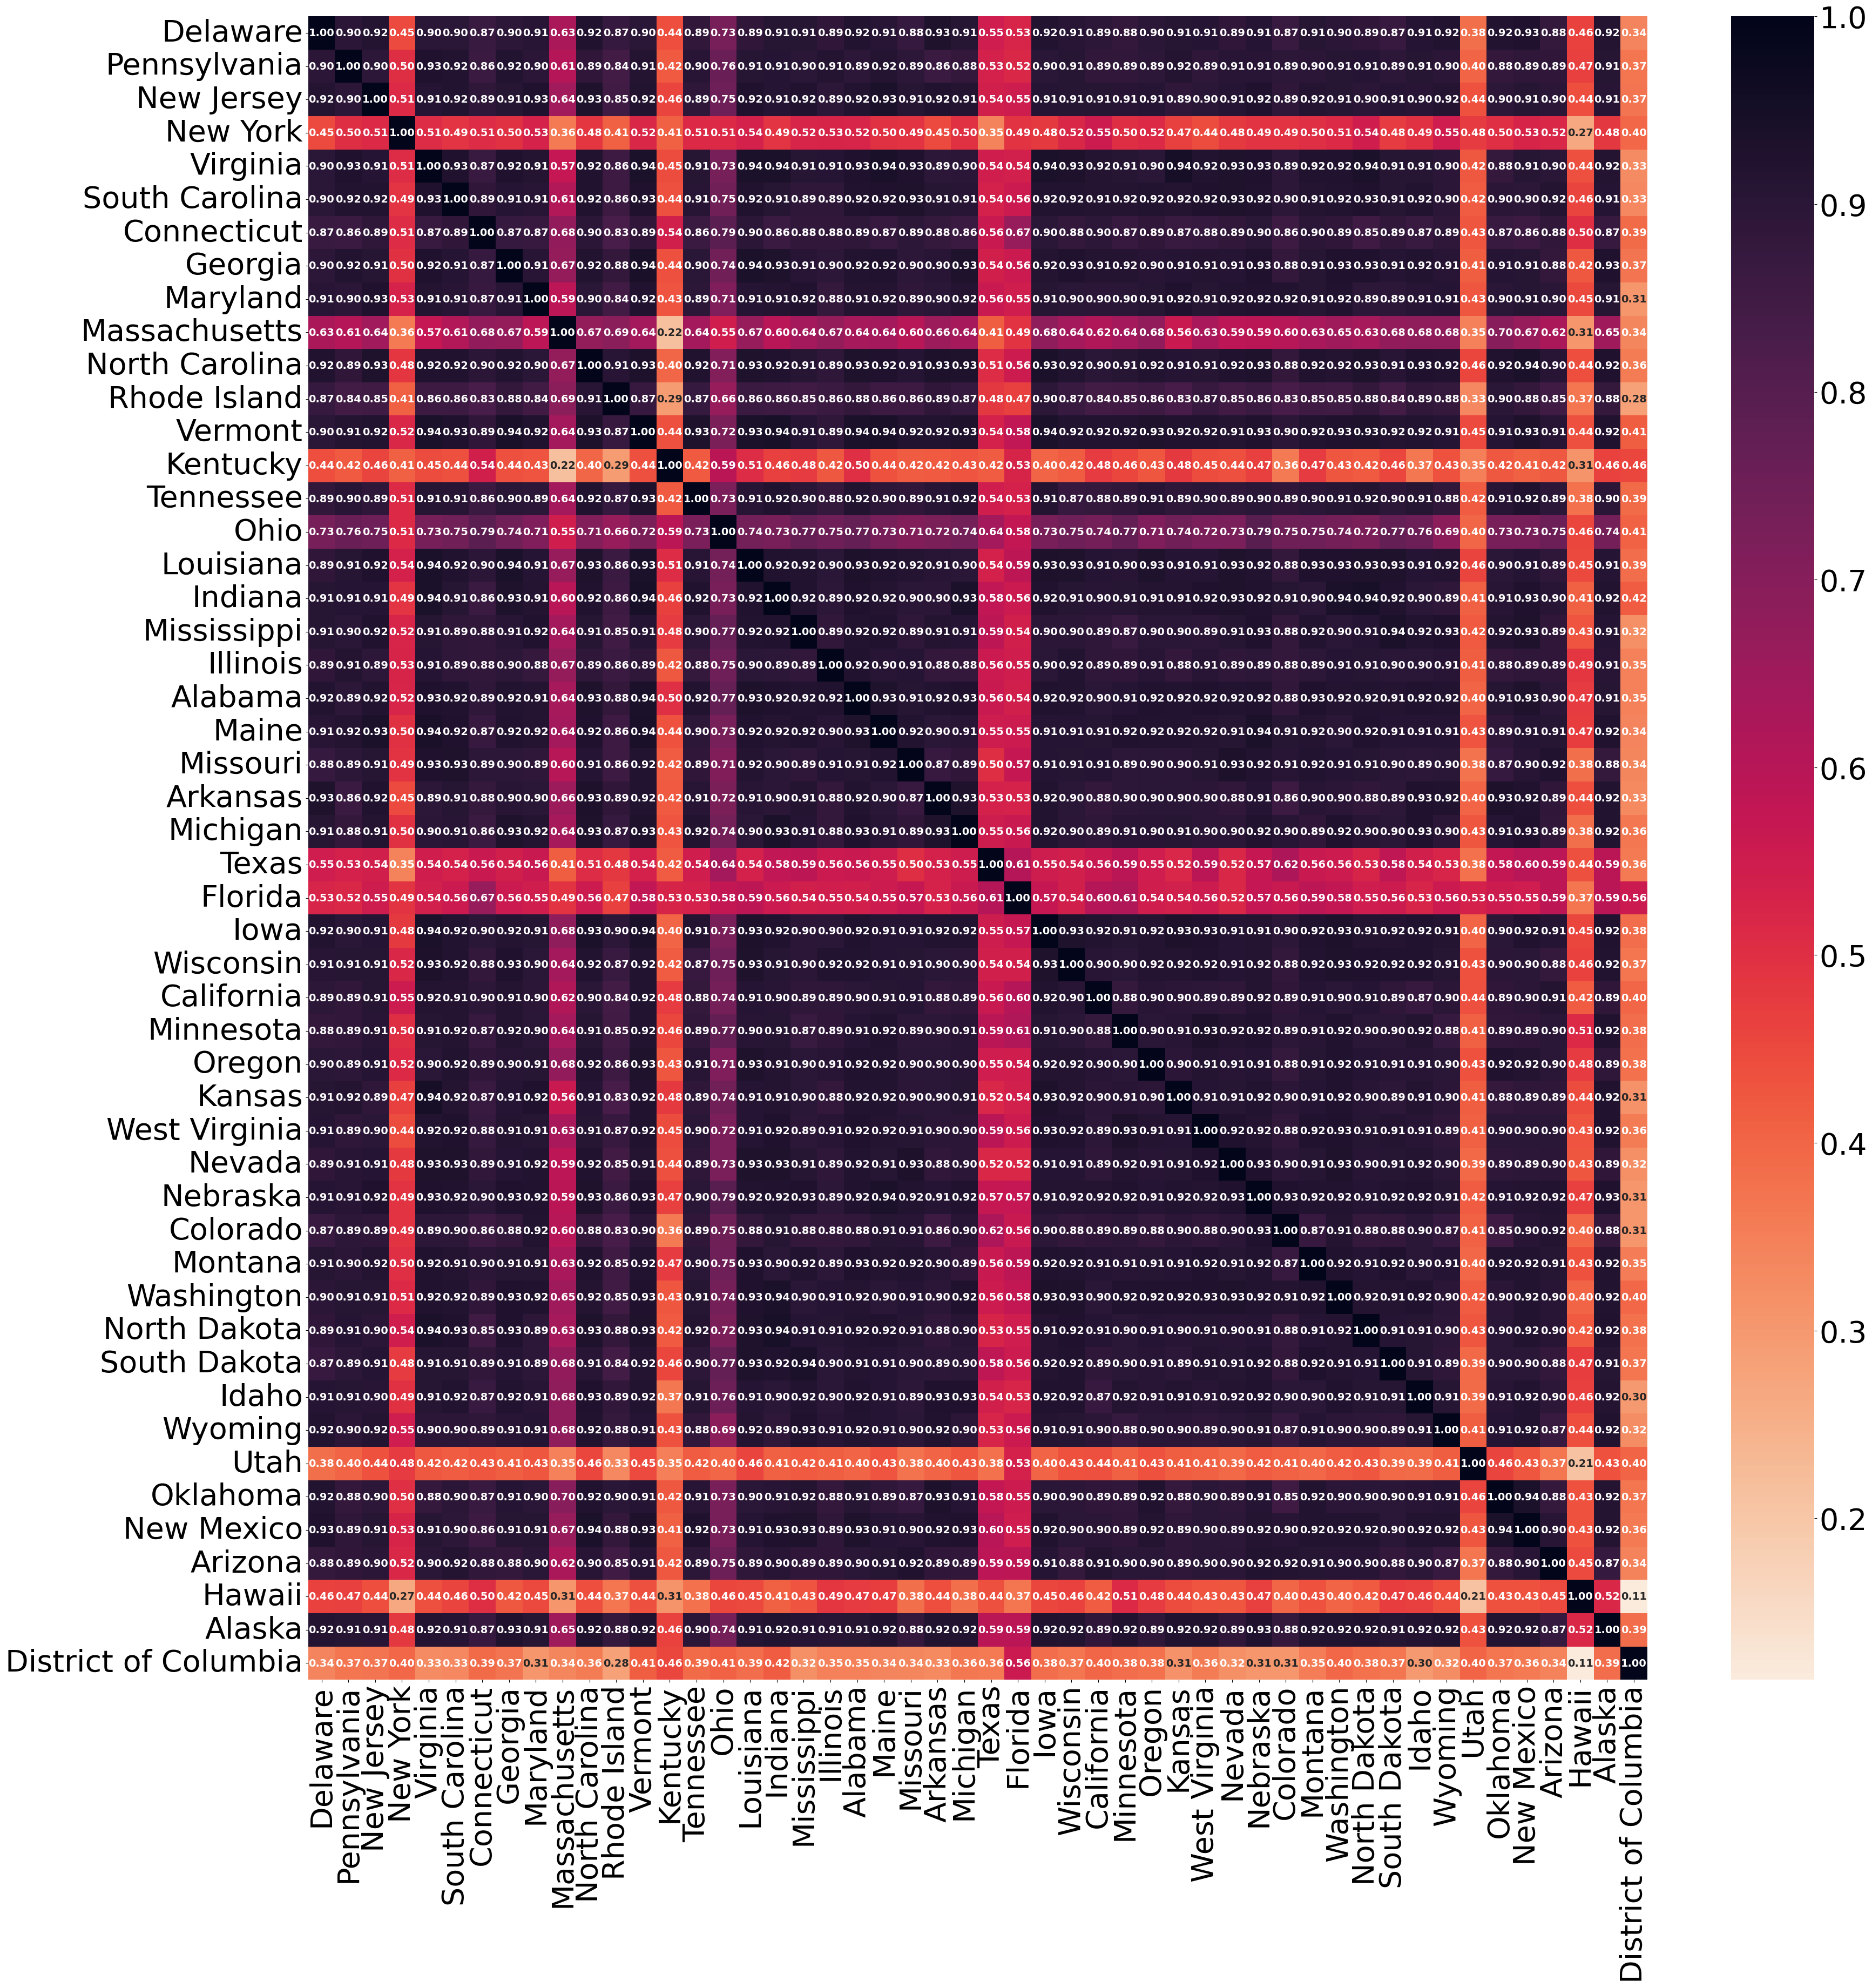

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

statehood_order = {
    'Delaware': 1787,
    'Pennsylvania': 1787,
    'New Jersey': 1787,
    'Georgia': 1788,
    'Connecticut': 1788,
    'Massachusetts': 1788,
    'Maryland': 1788,
    'South Carolina': 1788,
    'New Hampshire': 1788,
    'Virginia': 1788,
    'New York': 1788,
    'North Carolina': 1789,
    'Rhode Island': 1790,
    'Vermont': 1791,
    'Kentucky': 1792,
    'Tennessee': 1796,
    'Ohio': 1803,
    'Louisiana': 1812,
    'Indiana': 1816,
    'Mississippi': 1817,
    'Illinois': 1818,
    'Alabama': 1819,
    'Maine': 1820,
    'Missouri': 1821,
    'Arkansas': 1836,
    'Michigan': 1837,
    'Florida': 1845,
    'Texas': 1845,
    'Iowa': 1846,
    'Wisconsin': 1848,
    'California': 1850,
    'Minnesota': 1858,
    'Oregon': 1859,
    'Kansas': 1861,
    'West Virginia': 1863,
    'Nevada': 1864,
    'Nebraska': 1867,
    'Colorado': 1876,
    'North Dakota': 1889,
    'South Dakota': 1889,
    'Montana': 1889,
    'Washington': 1889,
    'Idaho': 1890,
    'Wyoming': 1890,
    'Utah': 1896,
    'Oklahoma': 1907,
    'New Mexico': 1912,
    'Arizona': 1912,
    'Alaska': 1959,
    'Hawaii': 1959,
}

# Create a dataframe to store cosine similarity between state vectors
cosine_similarity_matrix = pd.DataFrame(np.zeros((len(state_name), len(state_name))), columns=state_name, index=state_name)

# Calculate cosine similarity between state vectors
for i in range(len(state_name)):
    for j in range(i, len(state_name)):
        cosine_sim = cosine_similarity([coolie_vector[i]], [coolie_vector[j]])[0][0]
        cosine_similarity_matrix.at[state_name[i], state_name[j]] = cosine_sim
        cosine_similarity_matrix.at[state_name[j], state_name[i]] = cosine_sim  # Fill both sides of the matrix

# Sort states based on statehood order
state_name_sorted = sorted(state_name, key=lambda x: statehood_order.get(x, float('inf')))

# Reorder rows and columns of the cosine similarity matrix
cosine_similarity_matrix = cosine_similarity_matrix.reindex(index=state_name_sorted, columns=state_name_sorted)

# Create a heatmap
plt.figure(figsize=(40, 40))
ax = sns.heatmap(cosine_similarity_matrix, annot=True, cmap="rocket_r", annot_kws={"size": 14, "fontweight":"bold"}, fmt='.2f')
# plt.title("Cosine Similarity between States", fontsize=20)

# Increase x-axis and y-axis tick label font size
ax.set_xticklabels(ax.get_xticklabels(), fontsize=40)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=40)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=40)

# plt.savefig('eacl2023_latex/figure/heatmap-200.pdf', bbox_inches='tight', dpi=200)
# plt.savefig('eacl2023_latex/figure/heatmap-200.png', bbox_inches='tight')

plt.show()


In [17]:
model=Word2Vec([row for row in df[df['state_str']=='New York']['ocr_sent_token']])
model.wv.most_similar('coolie', topn=30)

[('slave', 0.7271683812141418),
 ('tade', 0.709991991519928),
 ('chinese', 0.7091442346572876),
 ('laborer', 0.6782084703445435),
 ('trde', 0.6698806285858154),
 ('china', 0.6616024971008301),
 ('thechinese', 0.6612061262130737),
 ('labrer', 0.6570369601249695),
 ('cinee', 0.6566349864006042),
 ('labr', 0.6519914269447327),
 ('hong', 0.6359202861785889),
 ('african', 0.6357375383377075),
 ('ship', 0.6354643106460571),
 ('intrade', 0.6345893740653992),
 ('ooolle', 0.6339715719223022),
 ('lbor', 0.6321159601211548),
 ('vessel', 0.6296513080596924),
 ('thelabor', 0.6263099908828735),
 ('thchinese', 0.6238950490951538),
 ('negro', 0.6230143904685974),
 ('oftrade', 0.6167545318603516),
 ('chlnl', 0.6159387826919556),
 ('trdo', 0.6144124865531921),
 ('portuguese', 0.6039309501647949),
 ('kong', 0.5978356599807739),
 ('clne', 0.5977620482444763),
 ('aud', 0.5974504947662354),
 ('labrr', 0.5960792303085327),
 ('ilbr', 0.5916811227798462),
 ('ofchinese', 0.5914764404296875)]

In [18]:
model=Word2Vec([row for row in df[df['state_str']=='Kentucky']['ocr_sent_token']])
model.wv.most_similar('coolie', topn=30)

[('chinese', 0.9386171102523804),
 ('japanese', 0.9151578545570374),
 ('smuggle', 0.9034671187400818),
 ('island', 0.8874842524528503),
 ('carry', 0.8858096599578857),
 ('china', 0.877051591873169),
 ('vessel', 0.870863676071167),
 ('laborer', 0.8650296330451965),
 ('labor', 0.8649747371673584),
 ('soldier', 0.856133759021759),
 ('aro', 0.8549503684043884),
 ('tance', 0.8517671227455139),
 ('ship', 0.8482882380485535),
 ('force', 0.846487283706665),
 ('hawaii', 0.8452732563018799),
 ('gun', 0.8403052687644958),
 ('upon', 0.8400566577911377),
 ('cover', 0.836614727973938),
 ('ground', 0.8290756940841675),
 ('japan', 0.8256879448890686),
 ('servile', 0.8243678212165833),
 ('measure', 0.8236948847770691),
 ('shoul', 0.8230261206626892),
 ('ing', 0.8227458596229553),
 ('lighter', 0.8222293853759766),
 ('thus', 0.8218623399734497),
 ('boycott', 0.8216673731803894),
 ('philippine', 0.8212059140205383),
 ('elevation', 0.8191667199134827),
 ('mongolian', 0.8185833692550659)]

In [20]:
model=Word2Vec([row for row in df[df['state_str']=='Utah']['ocr_sent_token']])
model.wv.most_similar('coolie', topn=30)

[('laborer', 0.8621002435684204),
 ('chinese', 0.8096421360969543),
 ('thecoolie', 0.8088929653167725),
 ('coole', 0.7917646169662476),
 ('coolielabor', 0.767024040222168),
 ('ofchinese', 0.7448689341545105),
 ('chinesei', 0.7417113184928894),
 ('coollo', 0.726188063621521),
 ('chinaman', 0.7244488000869751),
 ('skilled', 0.7081102728843689),
 ('chin', 0.6994563341140747),
 ('chineselabor', 0.6992445588111877),
 ('slave', 0.6987446546554565),
 ('thechinese', 0.6983110904693604),
 ('importation', 0.6958099603652954),
 ('cooliesthe', 0.693523645401001),
 ('nese', 0.6900122761726379),
 ('ricksha', 0.687539279460907),
 ('chine', 0.6826419830322266),
 ('japanesecoolie', 0.6813341379165649),
 ('laborers', 0.6790288090705872),
 ('chinee', 0.6778327822685242),
 ('jap', 0.6767056584358215),
 ('planter', 0.6748754382133484),
 ('cooli', 0.671227216720581),
 ('asiatic', 0.6653098464012146),
 ('laborfor', 0.6614766716957092),
 ('japanese', 0.6609898209571838),
 ('chln', 0.6597397923469543),
 ('kore

In [21]:
model=Word2Vec([row for row in df[df['state_str']=='Hawaii']['ocr_sent_token']])
model.wv.most_similar('coolie', topn=30)

[('east', 0.7252323627471924),
 ('contract', 0.7103397846221924),
 ('chinese', 0.6981859803199768),
 ('laborer', 0.6913618445396423),
 ('slave', 0.6664328575134277),
 ('immigrant', 0.6647303104400635),
 ('cooly', 0.6448026299476624),
 ('contra', 0.6437777280807495),
 ('india', 0.6423163414001465),
 ('employ', 0.6393750905990601),
 ('labor', 0.6388964653015137),
 ('kast', 0.6346771121025085),
 ('field', 0.6342437863349915),
 ('plantation', 0.6313108801841736),
 ('er', 0.6287306547164917),
 ('coolio', 0.6272971034049988),
 ('male', 0.6227609515190125),
 ('importation', 0.6212260723114014),
 ('japanese', 0.6209437251091003),
 ('japa', 0.6189690232276917),
 ('import', 0.6153206825256348),
 ('cereal', 0.6152235269546509),
 ('adulterated', 0.6127870082855225),
 ('cheap', 0.6112341284751892),
 ('confound', 0.6076977252960205),
 ('chi', 0.6063341498374939),
 ('malarial', 0.6028969883918762),
 ('scarcity', 0.600269615650177),
 ('erson', 0.5974152088165283),
 ('nese', 0.5967128872871399)]

In [22]:
model=Word2Vec([row for row in df[df['state_str']=='California']['ocr_sent_token']])
model.wv.most_similar('coolie', topn=30)

[('work', 0.9978461265563965),
 ('man', 0.9977481365203857),
 ('could', 0.9976711869239807),
 ('wage', 0.9976276755332947),
 ('long', 0.9974786639213562),
 ('family', 0.9974046349525452),
 ('interest', 0.9974040985107422),
 ('army', 0.9973878264427185),
 ('place', 0.9973797798156738),
 ('little', 0.9973627328872681),
 ('ber', 0.997346043586731),
 ('soldier', 0.997302770614624),
 ('without', 0.9972829818725586),
 ('upon', 0.9972627758979797),
 ('poor', 0.9972554445266724),
 ('big', 0.9972327351570129),
 ('form', 0.9972172379493713),
 ('always', 0.9972088932991028),
 ('home', 0.9972087740898132),
 ('build', 0.9972079992294312),
 ('still', 0.9972030520439148),
 ('also', 0.997199296951294),
 ('clothe', 0.997195839881897),
 ('month', 0.9971908926963806),
 ('per', 0.9971907138824463),
 ('take', 0.9971902370452881),
 ('offer', 0.9971882104873657),
 ('un', 0.9971774220466614),
 ('system', 0.9971664547920227),
 ('necessary', 0.9971653819084167)]

In [23]:
model=Word2Vec([row for row in df[df['state_str']=='Illinois']['ocr_sent_token']])
model.wv.most_similar('coolie', topn=30)

[('give', 0.9997143149375916),
 ('every', 0.9996867775917053),
 ('n', 0.9996843338012695),
 ('country', 0.9996792078018188),
 ('make', 0.9996772408485413),
 ('find', 0.9996766448020935),
 ('upon', 0.9996753334999084),
 ('la', 0.9996698498725891),
 ('one', 0.999669075012207),
 ('union', 0.9996679425239563),
 ('I', 0.999666154384613),
 ('ot', 0.9996650218963623),
 ('look', 0.9996616244316101),
 ('de', 0.9996606111526489),
 ('may', 0.9996594786643982),
 ('carry', 0.9996572136878967),
 ('house', 0.9996550679206848),
 ('tbe', 0.9996526837348938),
 ('strike', 0.9996466040611267),
 ('laborer', 0.9996463060379028),
 ('bill', 0.9996446967124939),
 ('time', 0.9996431469917297),
 ('like', 0.9996412992477417),
 ('lie', 0.9996404647827148),
 ('con', 0.9996396899223328),
 ('government', 0.9996374249458313),
 ('go', 0.9996373653411865),
 ('tion', 0.9996365904808044),
 ('large', 0.9996336102485657),
 ('fact', 0.9996333718299866)]

In [24]:
model=Word2Vec([row for row in df[df['state_str']=='Michigan']['ocr_sent_token']])
model.wv.most_similar('coolie', topn=30)

[('would', 0.9997893571853638),
 ('tho', 0.999786376953125),
 ('chinese', 0.9997657537460327),
 ('labor', 0.9997552633285522),
 ('make', 0.999752938747406),
 ('I', 0.9997127652168274),
 ('work', 0.9996967315673828),
 ('time', 0.9996861219406128),
 ('american', 0.9996692538261414),
 ('long', 0.9996641874313354),
 ('one', 0.999650239944458),
 ('way', 0.9996418952941895),
 ('country', 0.9996417760848999),
 ('j', 0.9996219277381897),
 ('japan', 0.9996218681335449),
 ('great', 0.9996170997619629),
 ('man', 0.9996011257171631),
 ('carry', 0.9995952844619751),
 ('china', 0.9995899200439453),
 ('day', 0.999588131904602),
 ('government', 0.9995748996734619),
 ('state', 0.999567449092865),
 ('line', 0.9995623230934143),
 ('ship', 0.9995465874671936),
 ('say', 0.9995396137237549),
 ('ing', 0.9995372891426086),
 ('go', 0.9995301961898804),
 ('japanese', 0.9995259642601013),
 ('wage', 0.9995169639587402),
 ('take', 0.9995115399360657)]